In [1]:
import gym

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from collections import namedtuple

from DDQN import DDQN
from DDPG import DDPG, Transition
from Actor_Critic import Actor_Critic
from config import config
from off_policy import off_policy_train

## SETTING

In [2]:
#== CONFIGURATION ==
print('='*4 + ' CONFIGURATION ' + '='*4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
CONFIG = config(RENDER=False, LR_A=1e-2, LR_C=1e-3, GAMMA=0.9, ENV_NAME='CartPole-v0', MAX_EPISODES=1000)
for key, value in CONFIG.__dict__.items():
    if key[:1] != '_': print(key, value) 

==== CONFIGURATION ====
cpu
MAX_EPISODES 1000
MAX_EP_STEPS 200
LR_A 0.01
LR_A_END 0.0001
LR_C 0.001
LR_C_END 0.0001
EPSILON 0.9
EPSILON_END 0.05
MEMORY_CAPACITY 10000
BATCH_SIZE 32
GAMMA 0.9
TAU 0.01
HARD_UPDATE 200
SOFT_UPDATE True
RENDER False
ENV_NAME CartPole-v0
MAX_MODEL 5
DOUBLE True


### ENVIRONMENT

In [3]:
#== Cart Pole ==
# An episode ends when (1) |x| >= 2.4 (2) |theta| >= 12 deg (3) episode length > 200
env = gym.make(CONFIG.ENV_NAME)
env.seed(0)
s_dim = env.observation_space.shape[0]
#a_dim = env.action_space.shape[0]
print(s_dim)

action_num = 2
action_list = np.array([0,1]).reshape(-1,1)

running_reward_th = env.spec.reward_threshold
print(running_reward_th)

4
195.0


### DDPG

In [4]:
agent=DDPG(s_dim, 1, device, CONFIG)
TrainingRecord = namedtuple('TrainingRecord', ['ep', 'avg_reward', 'reward', 'loss_a', 'loss_c'])

training_records = []
running_reward = 0
for ep in range(CONFIG.MAX_EPISODES):
    s = env.reset()
    ep_reward = 0.
    for step_num in range(CONFIG.MAX_EP_STEPS):
        print('\r {:d}'.format(step_num), end='')
        if CONFIG.RENDER:
            env.render()
        # action selection
        a = agent.select_action(s) # output is in [-1, 1]
        if a < 0:
            act = 0
        else:
            act = 1

        # interact with env
        s_, r, done, _ = env.step(act)
        ep_reward += r
        if done:
            s_ = None

        # Store the transition in memory
        agent.store_transition(s, a, r, s_)
        s = s_

        # Perform one step of the optimization (on the target network)
        loss_a, loss_c = agent.update()
        if done:
            break
    running_reward = running_reward * 0.95 + ep_reward * 0.05
    training_records.append(TrainingRecord(ep, running_reward, ep_reward, loss_a, loss_c))

    if ep % 50 == 0:
        print('\rEp[{:3.0f}]: Running Reward: {:3.2f} \t Real Reward: {:.2f}'.format(ep, running_reward, ep_reward))
    if running_reward > running_reward_th:
        print("\rSolved! Running reward is now {:3.2f}!".format(running_reward))
        env.close()
        break
env.close()

Ep[  0]: Running Reward: 1.30 	 Real Reward: 26.00
Ep[ 50]: Running Reward: 14.27 	 Real Reward: 9.00
Ep[100]: Running Reward: 53.77 	 Real Reward: 54.00
Ep[150]: Running Reward: 139.39 	 Real Reward: 200.00
Ep[200]: Running Reward: 193.64 	 Real Reward: 200.00
Ep[250]: Running Reward: 185.95 	 Real Reward: 197.00
Solved! Running reward is now 195.24!


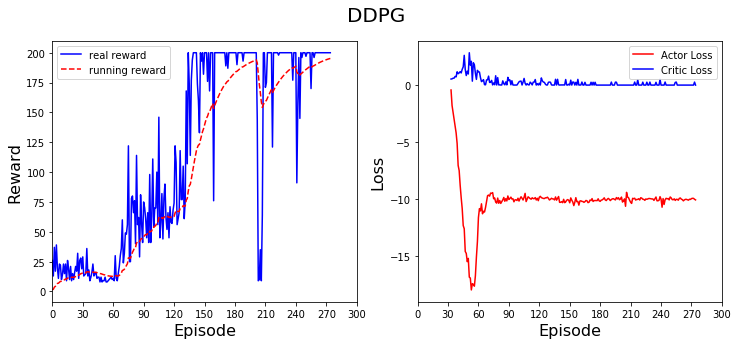

In [5]:
x_max = np.ceil(training_records[-1].ep / 100) * 100

fig = plt.figure(figsize=(12,4.8))
fig.suptitle('DDPG', fontsize=20)

ax = fig.add_subplot(121)
ax.plot([r.ep for r in training_records], [r.reward for r in training_records], 'b-', label='real reward')
ax.plot([r.ep for r in training_records], [r.avg_reward for r in training_records], 'r--', label='running reward')
ax.set_xlabel('Episode', fontsize=16)
ax.set_xticks(np.arange(0, x_max*1.1, x_max/10))
ax.set_xlim(0, x_max)
ax.set_ylabel('Reward', fontsize=16)
ax.legend()

ax = fig.add_subplot(122)
ax.plot([r.ep for r in training_records], [r.loss_a for r in training_records], 'r-', label='Actor Loss')
ax.plot([r.ep for r in training_records], [r.loss_c for r in training_records], 'b-', label='Critic Loss')
ax.legend()
ax.set_xlabel('Episode', fontsize=16)
ax.set_xticks(np.arange(0, x_max*1.1, x_max/10))
ax.set_xlim(0, x_max)
ax.set_ylabel('Loss', fontsize=16)
plt.savefig("../img/ddpg_cartpole.png")
plt.show()

### Actor-Critic

In [6]:
#== AGENT ==
CONFIG = config(RENDER=False, GAMMA=0.99, ENV_NAME='CartPole-v0', MAX_EPISODES=1000)
agent=Actor_Critic(s_dim, action_num, device, CONFIG, action_list)
TrainingRecord = namedtuple('TrainingRecord', ['ep', 'avg_reward', 'reward', 'loss_a', 'loss_c'])

training_records = []
running_reward = 0

for ep in range(CONFIG.MAX_EPISODES):
    s = env.reset()
    ep_reward = 0.
    reward_record = []
    for step_num in range(CONFIG.MAX_EP_STEPS):
        print('\r {:d}'.format(step_num), end='')
        if CONFIG.RENDER:
            env.render()
        # action selection
        a, a_idx = agent.select_action(s)

        # interact with env
        s_, r, done, _ = env.step(a[0])
        ep_reward += r
        if done:
            s_ = None

        # Store the transition in memory
        agent.store_transition(s, a_idx, r, s_)
        reward_record.append(r)
        s = s_
        
        if done:
            break
    # Perform one step of the optimization (on the target network)
    loss_a, loss_c = agent.update(reward_record)
    agent.actor_memory.reset()
    
    running_reward = running_reward * 0.95 + ep_reward * 0.05
    training_records.append(TrainingRecord(ep, running_reward, ep_reward, loss_a, loss_c))

    if ep % 50 == 0:
        print('\rEp[{:3.0f}]: Running Reward: {:3.2f} \t Real Reward: {:.2f}'.format(ep, running_reward, ep_reward))
    if running_reward > running_reward_th:
        print("\rSolved! Running reward is now {:3.2f}!".format(running_reward))
        env.close()
        break
env.close()

Ep[  0]: Running Reward: 0.65 	 Real Reward: 13.00
Ep[ 50]: Running Reward: 33.60 	 Real Reward: 77.00
Ep[100]: Running Reward: 38.45 	 Real Reward: 26.00
Ep[150]: Running Reward: 55.15 	 Real Reward: 70.00
Ep[200]: Running Reward: 94.72 	 Real Reward: 108.00
Ep[250]: Running Reward: 112.58 	 Real Reward: 144.00
Ep[300]: Running Reward: 145.93 	 Real Reward: 107.00
Ep[350]: Running Reward: 125.57 	 Real Reward: 200.00
Ep[400]: Running Reward: 166.40 	 Real Reward: 200.00
Ep[450]: Running Reward: 188.62 	 Real Reward: 200.00
Ep[500]: Running Reward: 185.49 	 Real Reward: 200.00
Ep[550]: Running Reward: 170.53 	 Real Reward: 200.00
Ep[600]: Running Reward: 169.33 	 Real Reward: 200.00
Ep[650]: Running Reward: 186.98 	 Real Reward: 200.00
Ep[700]: Running Reward: 192.44 	 Real Reward: 200.00
Solved! Running reward is now 195.07!


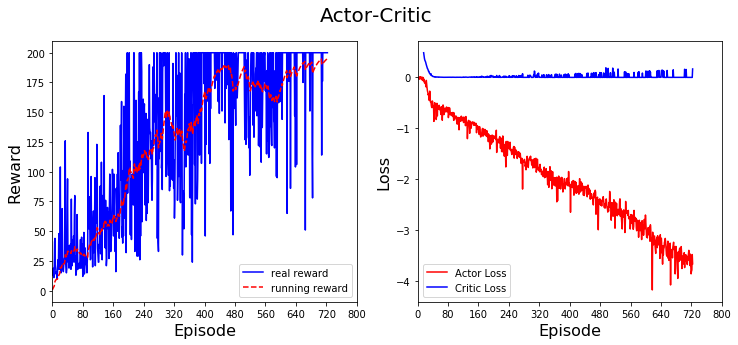

In [7]:
x_max = np.ceil(training_records[-1].ep / 100) * 100

fig = plt.figure(figsize=(12,4.8))
fig.suptitle('Actor-Critic', fontsize=20)

ax = fig.add_subplot(121)
ax.plot([r.ep for r in training_records], [r.reward for r in training_records], 'b-', label='real reward')
ax.plot([r.ep for r in training_records], [r.avg_reward for r in training_records], 'r--', label='running reward')
ax.set_xlabel('Episode', fontsize=16)
ax.set_xticks(np.arange(0, x_max*1.1, x_max/10))
ax.set_xlim(0, x_max)
ax.set_ylabel('Reward', fontsize=16)
ax.legend()

ax = fig.add_subplot(122)
ax.plot([r.ep for r in training_records], [r.loss_a for r in training_records], 'r-', label='Actor Loss')
ax.plot([r.ep for r in training_records], [r.loss_c for r in training_records], 'b-', label='Critic Loss')
ax.legend()
ax.set_xlabel('Episode', fontsize=16)
ax.set_xticks(np.arange(0, x_max*1.1, x_max/10))
ax.set_xlim(0, x_max)
ax.set_ylabel('Loss', fontsize=16)
plt.savefig("../img/actor_critic_cartpole.png")
plt.show()

### DDQN

In [8]:
CONFIG = config(RENDER=False, LR_A=1e-2, LR_C=1e-3, GAMMA=0.9, ENV_NAME='CartPole-v0', MAX_EPISODES=1000)
agent=DDQN(s_dim, action_num, device, CONFIG, action_list)

TrainingRecord = namedtuple('TrainingRecord', ['ep', 'avg_reward', 'reward', 'loss_c'])
training_records = []
running_reward = 0
for ep in range(CONFIG.MAX_EPISODES):
    s = env.reset()
    ep_reward = 0.
    for step_num in range(CONFIG.MAX_EP_STEPS):
        print('\r {:d}'.format(step_num), end='')
        if CONFIG.RENDER:
            env.render()
        # action selection
        a, a_idx = agent.select_action(s)

        # interact with env
        s_, r, done, _ = env.step(a[0])
        ep_reward += r
        if done:
            s_ = None

        # Store the transition in memory
        agent.store_transition(s, a_idx, r, s_)
        s = s_

        # Perform one step of the optimization (on the target network)
        loss_c = agent.update()
        if done:
            break
    running_reward = running_reward * 0.95 + ep_reward * 0.05
    training_records.append(TrainingRecord(ep, running_reward, ep_reward, loss_c))

    if ep % 10 == 0:
        print('\rEp[{:3.0f}]: Running Reward: {:3.2f} \t Real Reward: {:.2f}'.format(ep, running_reward, ep_reward))
    if running_reward > running_reward_th:
        print("\rSolved! Running reward is now {:3.2f}!".format(running_reward))
        env.close()
        break
env.close()


Ep[  0]: Running Reward: 1.85 	 Real Reward: 37.00
Ep[ 10]: Running Reward: 11.63 	 Real Reward: 36.00
Ep[ 20]: Running Reward: 15.69 	 Real Reward: 26.00
Ep[ 30]: Running Reward: 18.17 	 Real Reward: 13.00
Ep[ 40]: Running Reward: 18.18 	 Real Reward: 9.00
Ep[ 50]: Running Reward: 19.87 	 Real Reward: 21.00
Ep[ 60]: Running Reward: 25.93 	 Real Reward: 62.00
Ep[ 70]: Running Reward: 34.55 	 Real Reward: 54.00
Ep[ 80]: Running Reward: 55.83 	 Real Reward: 96.00
Ep[ 90]: Running Reward: 105.81 	 Real Reward: 197.00
Ep[100]: Running Reward: 140.69 	 Real Reward: 200.00
Ep[110]: Running Reward: 164.30 	 Real Reward: 200.00
Ep[120]: Running Reward: 177.38 	 Real Reward: 200.00
Ep[130]: Running Reward: 185.89 	 Real Reward: 200.00
Ep[140]: Running Reward: 186.27 	 Real Reward: 188.00
Ep[150]: Running Reward: 191.32 	 Real Reward: 200.00
Ep[160]: Running Reward: 193.90 	 Real Reward: 200.00
Solved! Running reward is now 195.03!


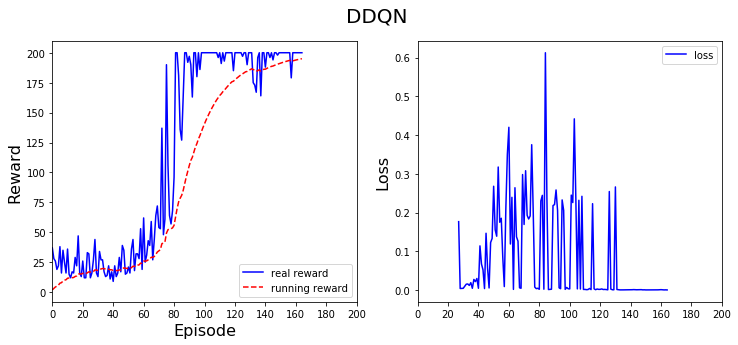

In [9]:
x_max = np.ceil(training_records[-1].ep / 100) * 100

fig = plt.figure(figsize=(12,4.8))
fig.suptitle('DDQN', fontsize=20)

ax = fig.add_subplot(121)
ax.plot([r.ep for r in training_records], [r.reward for r in training_records], 'b-', label='real reward')
ax.plot([r.ep for r in training_records], [r.avg_reward for r in training_records], 'r--', label='running reward')
ax.set_xlabel('Episode', fontsize=16)
ax.set_xticks(np.arange(0, x_max*1.1, x_max/10))
ax.set_xlim(0, x_max)
ax.set_ylabel('Reward', fontsize=16)
ax.legend()

ax = fig.add_subplot(122)
ax.plot([r.ep for r in training_records], [r.loss_c for r in training_records], 'b-', label='loss')
ax.legend()
ax.set_xticks(np.arange(0, x_max*1.1, x_max/10))
ax.set_xlim(0, x_max)
ax.set_ylabel('Loss', fontsize=16)
plt.savefig("../img/ddqn_cartpole.png")
plt.show()


## Evaluation

In [10]:
EVAL=False
if EVAL:
    s = env.reset()
    ep_reward = 0
    while (True):
        env.render()
        # action selection
        a, a_idx = agent.select_action(s)

        # interact with env
        s_, r, done, _ = env.step(a[0])
        ep_reward += r
        if done:
            print(s)
            break
        s = s_
    print(ep_reward)
    env.close()